# Supervised Learning. Classification

## Predicting bank customers churn

## Task description

A bank requested you for help: they want to develop a loyalty campaign to keep the customers. To include the customers in the campaign they want to be able to predict the probability of a customer leaving the bank and to be able to determine whether a customer will leave in the near time.

**Your goal** - build a classifier, which will in a timely manner allow to identify leaving customers, estimate the quality of the built models and interpret the results.

This task will consist of two parts:
* Prepare the data for modelling, build a simple logistic regression model, estimate its quality and and analyze the results of its work
* Build decision trees and random forest models, compare their results with the results of the logistic regression and make the final conclusions.

Bank data has a flat structure. It is a CSV file with the following attributes:
- RowNumber: number of the row in the table (irrelevant for the research)
- CustomerId: customer identifier
- Surname: customer surname
- CreditScore: customer credit score. The higher the value is, the better
- Geography: customer country
- Gender: customer gender
- Age: customer age
- Tenure: the number of years the customer is with the bank
- Balance: customer account balance in dollars
- NumOfProducts: number of products which the customer is using in the bank
- HasCrCard: indication if the customer has a credit card
- IsActiveMember: indication if the customer is currently actively using the bank account
- EstimatedSalary: estimated customer salary
- Exited: indication if the customer has already exited the relationship with the bank

First of all we import the necessary libraries.

In [295]:
import numpy as np 
import pandas as pd 
import plotly.express as px
import sys

from itertools import chain
from sklearn import linear_model 
from sklearn import metrics 
from sklearn import model_selection 
from sklearn import preprocessing 

sys.path.append('../../')

from DataScienceHelpers.ExploratoryDataAnalysis import display_histograms


Load data.

In [296]:
churn_data = pd.read_csv('../../data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Logistic Regression

In the first part you must complete the tasks 5.0–5.6.

### Task 5.0

For the completeness perform a limited exploratory data analysis. Prepare charts of the target feature distribution, as well as the diagrams and charts showing the relation between the factor features and the target feature.

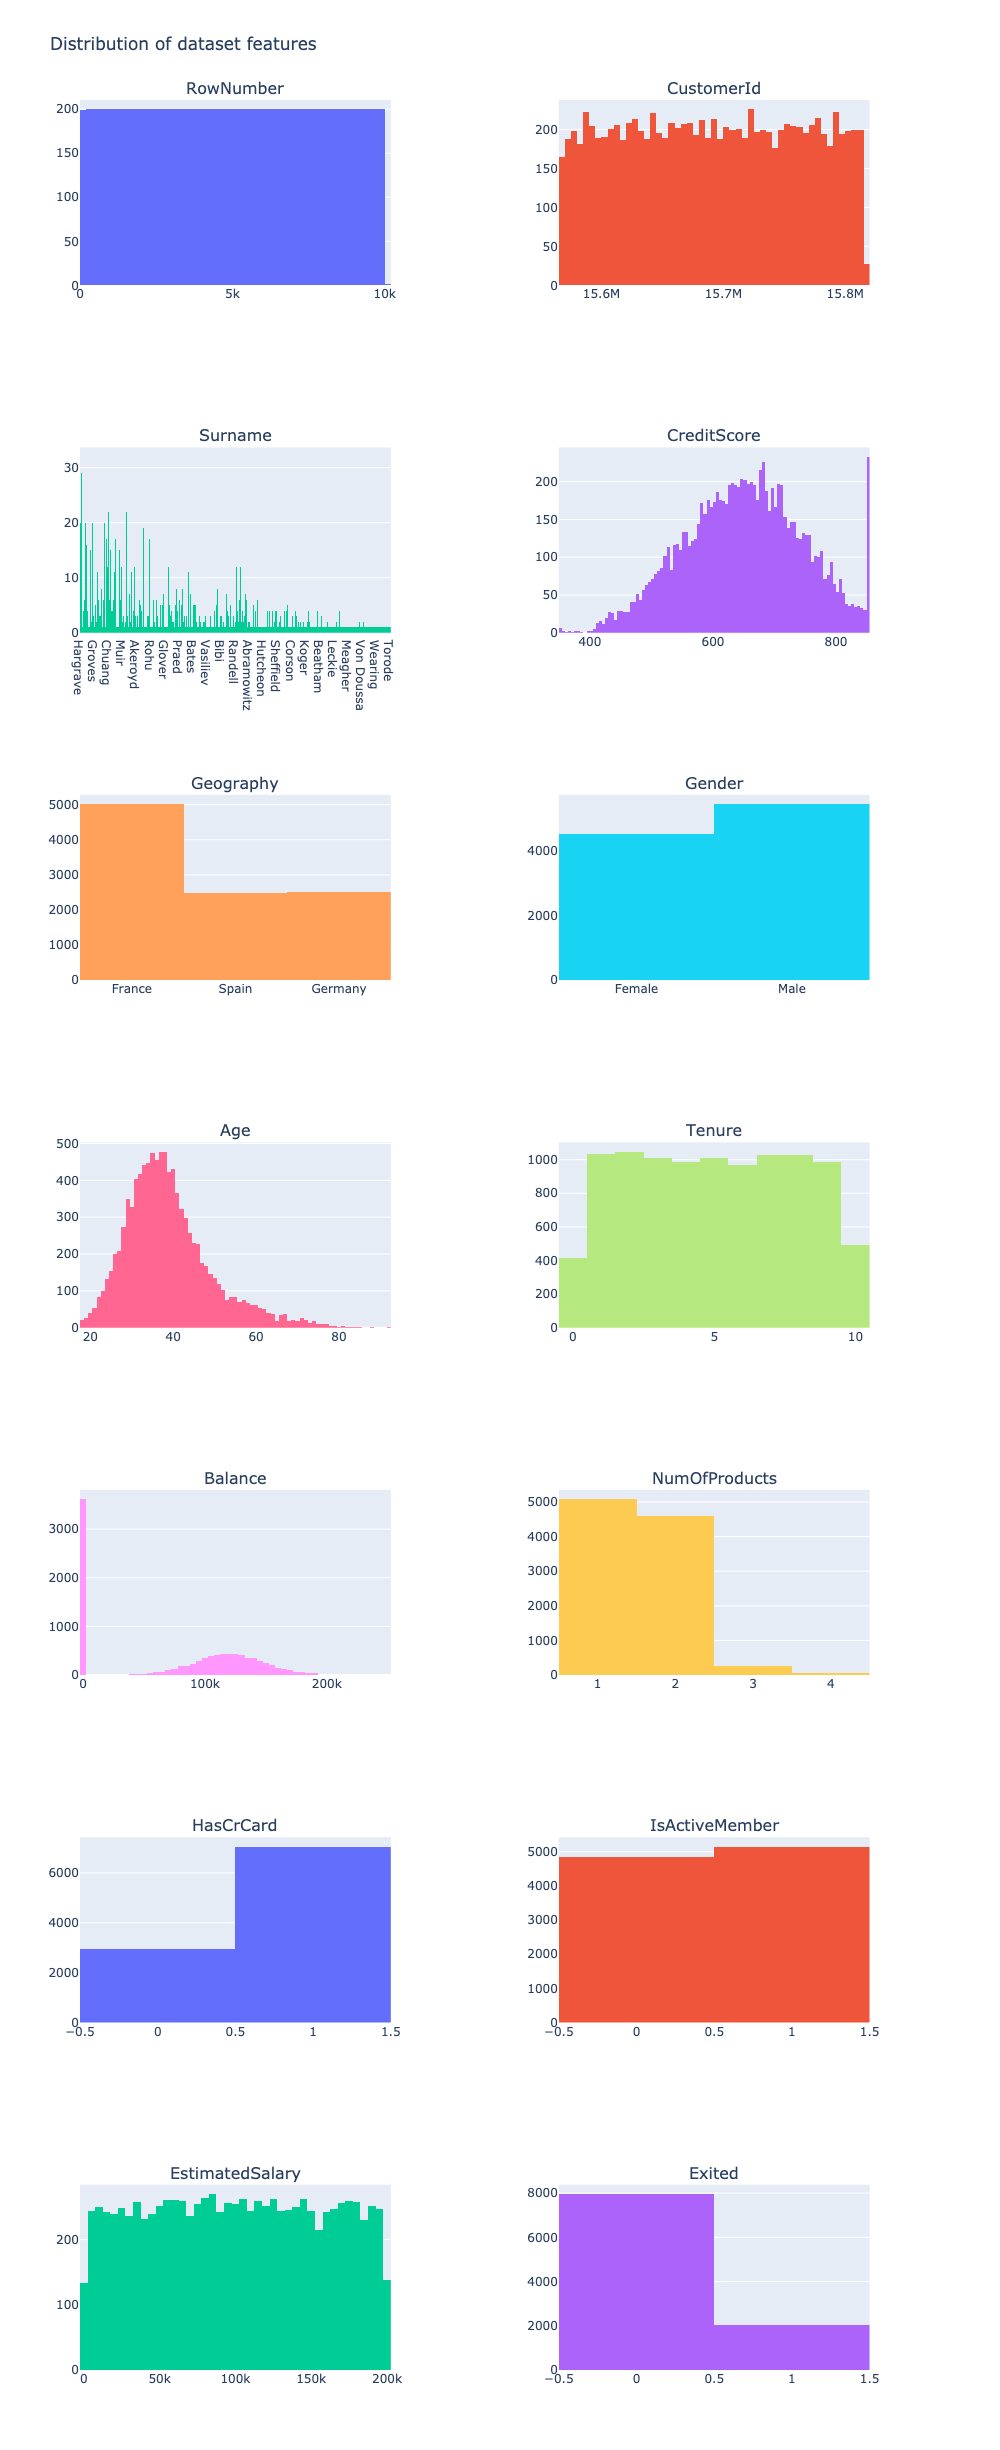

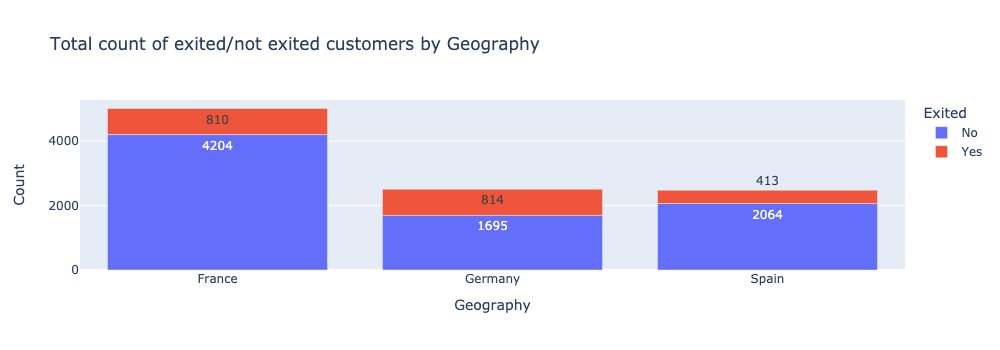

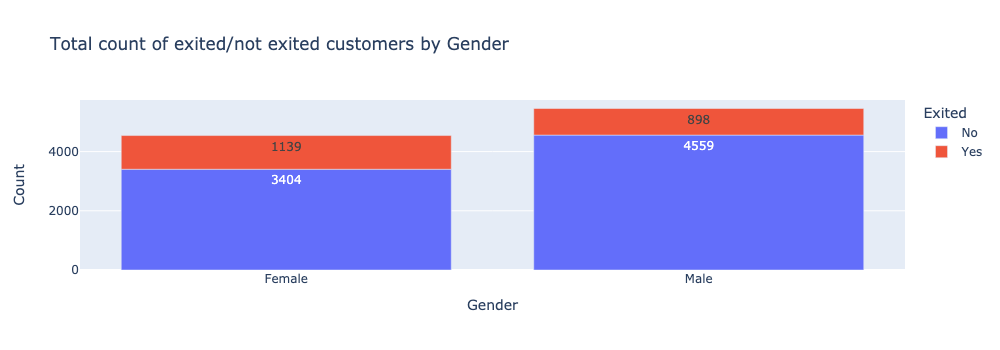

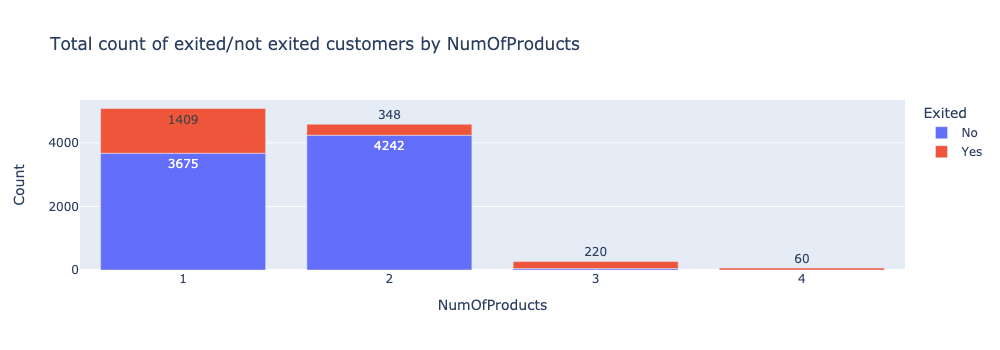

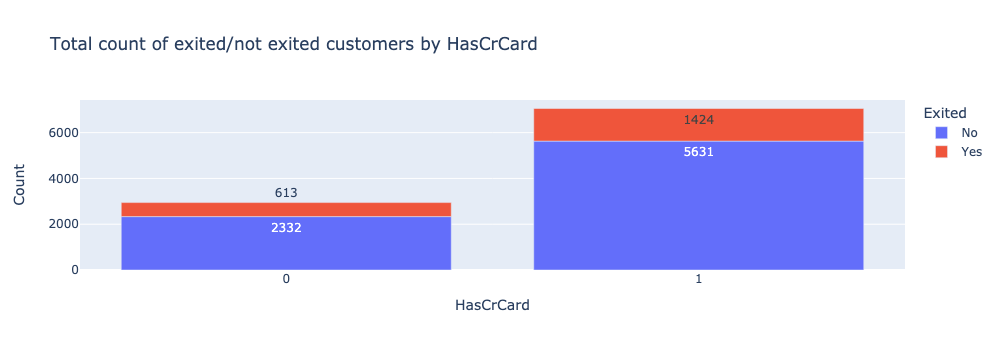

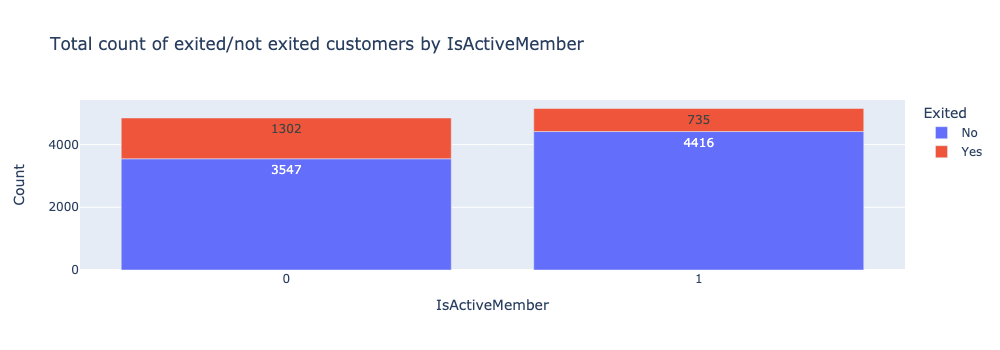

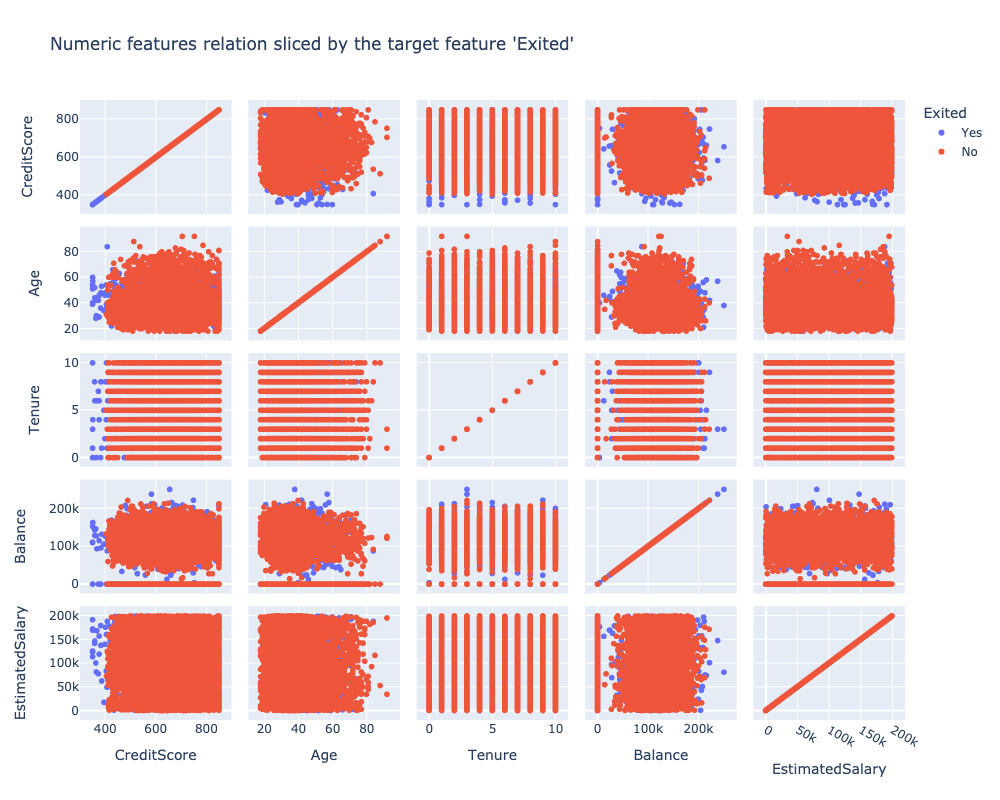

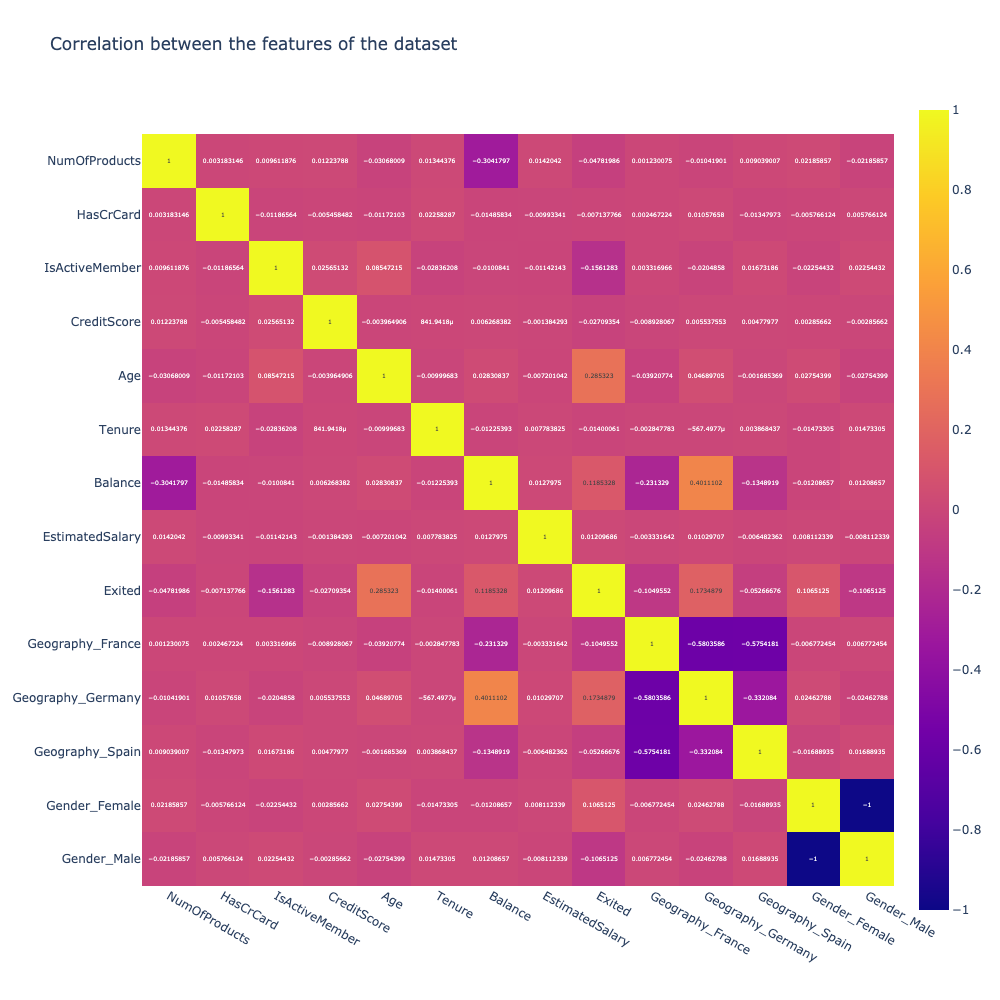

In [297]:
# Use a helper method to present distribution of features via histograms.
display_histograms(
    churn_data, 
    cols=2, 
    row_height=350, 
    title='Distribution of dataset features'
)

# Show relation between the categorical features and the target feature 'Exited'
cat_features = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
for feature in cat_features:
    exit_data = churn_data.groupby(['Exited', feature], as_index=False).count()[['Exited', feature, 'RowNumber']]
    exit_data['Count'] = exit_data['RowNumber']
    exit_data['Exited'] = exit_data['Exited'].apply(lambda x: 'Yes' if x == 1 else 'No')
    
    fig = px.bar(
        exit_data,
        x=feature,
        y='Count',
        color='Exited',
        width=1000,
        height=350,
        text_auto=True,
        title=f'Total count of exited/not exited customers by {feature}'
    ).update_layout(
        xaxis_tickvals=exit_data[feature].unique()
    )
    
    fig.show('png')

# Show relation between the categorical features and the target feature 'Exited'
num_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
churn_num = churn_data[num_features + ['Exited']].copy()
churn_num['Exited'] = churn_num['Exited'].apply(lambda x: 'Yes' if x == 1 else 'No')
fig = px.scatter_matrix(
    churn_num,
    dimensions=num_features,
    color='Exited',
    width=1000,
    height=800,
    title='Numeric features relation sliced by the target feature \'Exited\''
)
fig.show('png')

# Estimate multicolinearity in the dataset
churn_corr = churn_data[cat_features + num_features + ['Exited']].copy()
churn_corr = pd.get_dummies(churn_corr)
fig = px.imshow(
    churn_corr.corr(),
    text_auto=True,
    width=1000,
    height=1000,
    title='Correlation between the features of the dataset'
)
fig.show('png')

The distributions of features via histograms show that:
* The features 'CreditScore' and 'Balance' have a normal distribution with peaks respectively on the right and on the left sides. The feature 'Age' has a log-normal distribution.
* The features 'RowNumber', 'CustoermId' and 'Surname' are irrelevant for this model and must be deleted.
* The dataset is unbalanced in terms of the target feature 'Exited'. Around 20 % of customers have exited the relationship with the bank and around 80 % of the customers are remaining with the bank.

The analysis of categorical features have shown that:
* The ratio of exited customers is the highest in Germany.
* Also important is that females are more frequently exiting the bank relationship as well as customers having one product.

The analysis of numeric features have shown that there is no direct visual relation between any factor feature and the target feature. The only interesting observation is that the accounts with a low credit score have been exited and most probably proactively by the bank.

The visualization of the correlations show that there is a high correlation only in the sinthentic features 'Gender_Female' and 'Gender_Male' which were genereated out of the 'Gender' feature by the call to `get_dummies`. One of the both can be deleted.

Data visualization shows that the churn is different in France, Germany and Spain. Previous data scientists who already worked with this dataset came to a conclusion that the most efficient solution is to build models separately for each of the countries. We will build a model to predict the churn in the German department of the bank. So, let's pick the data related to Germany only.

In [298]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Let's get rid of the non-informative features which we have identified above. These are 'RowNumnber', 'CustomerId' and 'Surname'. Additionaly we'll drop the 'Geography' feature, since it now cnotains only 'Germany'.

In [299]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Let's check whethe the dataset has empty values:

In [300]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Let's check whether the dataset has duplicates:

In [301]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

### Task 5.1

Let's perform some data preprocessing.

First of all we'll extend the data set using Feature Engineering. Create the following features:
* 'BalanceSalaryRatio' - relation of the account balance to the customer salary;
* 'TenureByAge' - relation of the customer tenure to his or her age;
* 'CreditScoreGivenAge' - relation of the customer credit score to his or her age.

After that encode the categorical features to the binary numeric ones.

Output the statistical characteristics of the received features.

In [302]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']

churn_data = pd.get_dummies(churn_data, dtype='int')
# Deleting the 'Gender_Male' feature as it is multicolinear with the feature 'Gender_Female'
churn_data = churn_data.drop('Gender_Male', axis=1)

churn_data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Female
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487,0.475488
std,98.168937,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558,0.499498
min,350.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676,0.000000
25%,584.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275,0.000000
50%,651.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143,0.000000
75%,722.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941,1.000000
max,850.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889,1.000000


Split the original dataset to the feature matrix 'X' and the target feature column 'y'.

In [303]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Before splitting the data to train and test subsets let's check if the data is balanced.

In [304]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

It is obvious that the classes are not balanced. Exited customers are 32 % of the dataset where 68 % are loyal customers.

**What can be a consequence of unbalanced data?**

While splitting the data to train and test subsets it can happen that the train subset will contain only loyal customers or mostly loyal customers. Then there is a chance that the model will not learn how to determine a churn probability and the classification quality on the test subset will be low.

Or the other way around: only loyal customers will be included in the test subset. Then the model will show excellent results on the test subset, but it could be unusable in real life conditions.

We must ensure that the train and test subsets have the same ratio of exited and loyal customers. This kind of split is called **stratified**.

Function `train_test_split()` from the library `sklearn` can perform such a split. For that we need to set the parameter `stratify` to the feature which must have the same ratio in the train and test subsets. In our case it is the target feature 'y'.

Let's perform the split with the value of the `random_state` parameter equal to 0.

In [305]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Check if the number of exited and loyal customers is approximately the same in each of the subsets:

In [306]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

The ratios are approximately the same. We can move on the the next step.

### Task 5.2

Take care of the scaling of the features. Perform normalization/standardization of the feature matrix 'X' using the appropriate method `MinMaxScaler`/`RobustScaler` или `StandardScaler`.

Fit one of the scalers on the train dataset and apply the transformation to the train and test datasets.

We have seen above in the graphical analysis that only a few features have a normal distribution, with that we can exclude the `StandardScaler` from our selection. `MinMaxScaler` is sensitive to outliers, and since we did not clean the data from outliers, we should use the `RobustScaler`, which is not sensitive to outliers.

> **Note** However later in the experiments with the F1 metric I identified that the `MinMaxScaler` delivered better F1 metric results. Thus I will use it. An explanation of better results of the `MinMaxScaler` may be that there are not many outliers in the data, which can be confirmed by the visual exploratory data analysis performed in the task 5.0.

In [307]:
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

Now we can move on to modelling.

### Task 5.3

First of all let's identify the correct metric to evaluate the model quality.

The task is to determine customer churn in a timely manner. We know that to save the customers the bank will use the call center. The customers having a high exit probability will get special offers. The resources of the bank are limited, for this reason we need to minimize the number of the calls. But at the same time we need to keep as many customers as possible.

Thus we want to minimize both false positive and false negative outcomes of the model.

> Since the dataset is not balanced, we directly remove the metric 'accuracy' from the selection. The metric 'precision' is focusing on reducing the false positives, while the metric 'recall' is focusing on reducing the false negatives. None of the metrics is fully fitting our case, because we need to find a balance between the false posities and false negatives. For that we should pick the metric 'F1', which is used in the cases where a balance between false positives and false negatives is required.

### Task 5.4

Train a model of 'Logistic Regression' on the train dataset. To ensure that reproducible results are received, set the `random_state` parameter to a specific number, e.g. 42.

Make a prediction of classes for the train and test data.

Calculate the values of the selected metric on the train and test data.

Interpret the received results by answering the following question: is your model overfitted or underfitted?

> **Note** We consider that a model is underfitted if the metric's value on the test data is less than 0.5.

**Additional task:**

Experiment with the following model paramters:
* `penalty` - type of used regularization ('l1' - $L_1$-regularization, 'l2' - $L_2$-regularization)
* `C` - coefficient which is inverse to the regularization coefficient (default is 1)

Observe the metric values depending on the regularization type and increasing/decreasing the value of `C`.

F1 train default: 0.49
F1 test default: 0.47


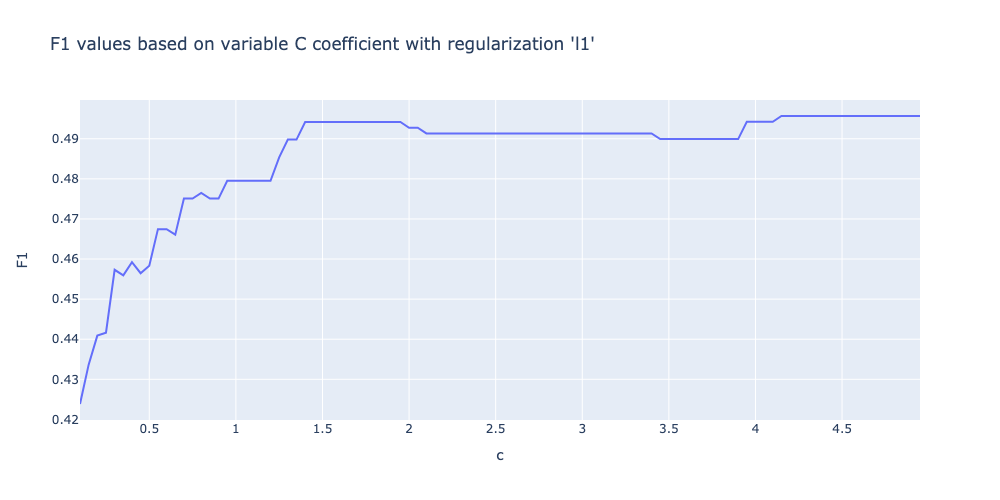

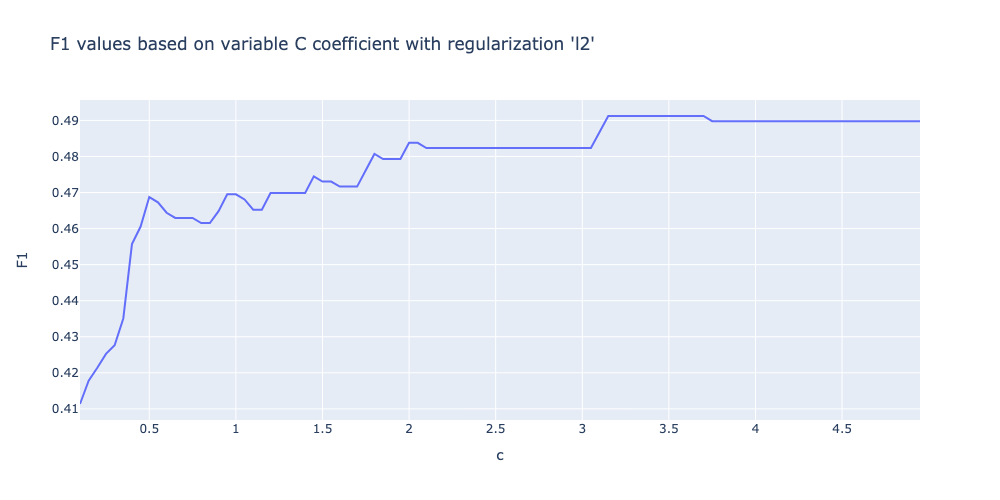

In [310]:
# Builiding a logistic regression model based on the scaled features
# Settings 'max_iter' due to model warning
lr_model = linear_model.LogisticRegression(
    solver='liblinear', 
    random_state=42, 
    max_iter=1000
)
lr_model.fit(X_train_scaled, y_train)
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

f1_train = metrics.f1_score(y_train, y_train_pred)
f1_test = metrics.f1_score(y_test, y_test_pred)

print(f'F1 train default: {f1_train:.2f}')
print(f'F1 test default: {f1_test:.2f}')

# Experimenting with regularization and C coefficient
def experimental_logistic_regression(regularization):
    cs = np.arange(0.1, 5, 0.05)
    f1_scores = []
    for c in cs:
        lr_model = linear_model.LogisticRegression(
            solver='liblinear', 
            C=c, 
            penalty=regularization, 
            random_state=42, 
            max_iter=1000
        )
        lr_model.fit(X_train_scaled, y_train)
        y_test_pred = lr_model.predict(X_test_scaled)

        f1_scores.append(metrics.f1_score(y_test, y_test_pred))

    df_f1 = pd.DataFrame(
        {
            'F1': f1_scores,
            'c': cs
        }
    )
    fig = px.line(
        df_f1,
        x='c',
        y='F1',
        width=1000,
        height=500,
        title=f'F1 values based on variable C coefficient with regularization \'{regularization}\''
    )
    fig.show('png')

experimental_logistic_regression('l1')
experimental_logistic_regression('l2')


> With default settings the F1 metric for the train dataset is 0.49 and for the test dataset is 0.47. Based on our agreement, the model is underfitted, since the metrics are below 0.5. It is also not overfitted, because there is no substantial difference between the metric of the train and test data. For an overfitted model the train data metric would be substantially higher than the test data metric.

> Expreriments with the regularization and the coefficient C have delivered the following results for the test data:
> * $L_1$ regularization has the highest F1 metric with C=4.15 - 0.496
> * $L_2$ regularization has the highest F1 metric with C=3.15 - 0.491
> 
> It is surprizing that the F1 metric has some a curve based on the C-coefficient, although both regularizations are reaching some level of saturation. All in all, we could find a C-coefficient which delivered us a higher F1 metric value than the default value of the C-coefficient.

### Task 5.5

Generate polinomial features of degree 3 for both train and test datasets. Use the class `PolynomialFeatures` from the `sklearn` library. Set `False` to the ìnclude_bias`parameter.

> **Note** Pay attention that to generate polynoms it is necessary to use scaled data.

Train a model of 'Logistic Regression' based on polynomial features. To ensure that reproducible results are received, set the `random_state` parameter to a specific number, e.g. 42.

Make a prediction of classes for the train and test data.

Calculate the values of the selected metric on the train and test data for the model trained on the polynomial features.

Compare with the result received in the task 5.4.

**Additional task:**

Experiment with the following model paramters:
* `penalty` - type of used regularization ('l1' - $L_1$-regularization, 'l2' - $L_2$-regularization)
* `C` - coefficient which is inverse to the regularization coefficient (default is 1)

Observe the metric values depending on the regularization type and increasing/decreasing the value of `C`.

F1 train default: 0.65
F1 test default: 0.65


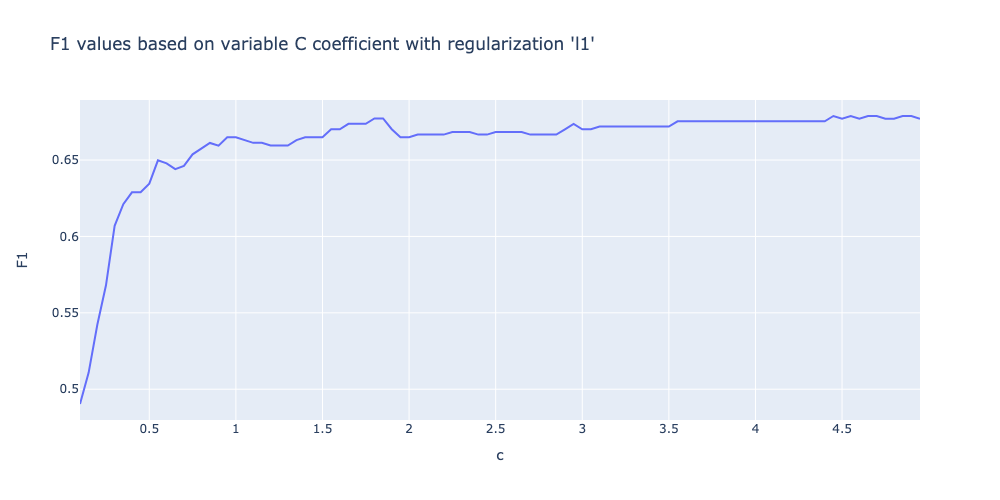

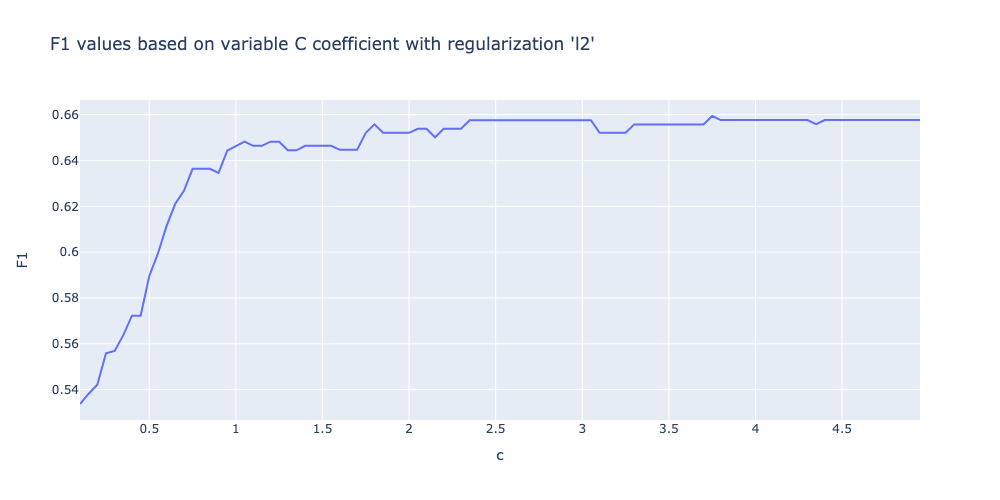

In [315]:
# Generating the polynomial features using the scaled features
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled)
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

# Building a logistic regression model based on polynomial features
lr_model = linear_model.LogisticRegression(
    solver='liblinear', 
    random_state=42, 
    max_iter=1000
)
lr_model.fit(X_train_scaled_poly, y_train)
y_train_pred = lr_model.predict(X_train_scaled_poly)
y_test_pred = lr_model.predict(X_test_scaled_poly)

f1_train = metrics.f1_score(y_train, y_train_pred)
f1_test = metrics.f1_score(y_test, y_test_pred)

print(f'F1 train default: {f1_train:.2f}')
print(f'F1 test default: {f1_test:.2f}')

# Experimenting with regularization and C coefficient
def experimental_logistic_regression(regularization):
    cs = np.arange(0.1, 5, 0.05)
    f1_scores = []
    for c in cs:
        lr_model = linear_model.LogisticRegression(
            solver='liblinear', 
            C=c, 
            penalty=regularization, 
            random_state=42, 
            max_iter=1000
        )
        lr_model.fit(X_train_scaled_poly, y_train)
        y_test_pred = lr_model.predict(X_test_scaled_poly)

        f1_scores.append(metrics.f1_score(y_test, y_test_pred))

    df_f1 = pd.DataFrame(
        {
            'F1': f1_scores,
            'c': cs
        }
    )
    fig = px.line(
        df_f1,
        x='c',
        y='F1',
        width=1000,
        height=500,
        title=f'F1 values based on variable C coefficient with regularization \'{regularization}\''
    )
    fig.show('png')

experimental_logistic_regression('l1')
experimental_logistic_regression('l2')


> The F1 metric has the value 0.65 for both train and test data. It is substantially higher than in the task 5.4. Which demonstrates that in this case the usage of polynomial features has improved the model. Also the model is not overfitted, since the test data has the same F1 metric as the train data. In the overfitting case the metrics on the train data are substantially better than those on the test data.
>
> Out of curiosity I have tried the polynomial features with the degrees 2 and 4. With the degree 2 the F1 metric is slightly lower than with the degree 3. With the degree 4 we are getting the sighns of overfittins, because the F1 metric on train data is 0.69 and on test data it is 0.65.

> Expreriments with the regularization and the coefficient C have delivered the following results for the test data:
> * $L_1$ regularization has the highest F1 metric with C=4.45 - 0.679
> * $L_2$ regularization has the highest F1 metric with C=3.75 - 0.659
> 
> The received results are higher than the values received with the default values of the C-coefficient. For the current case the $L_1$ regularization looks to be a better match.

### Task 5.6

Try to find out the probability threshold, at which the highest value of the target metric is achieved for the test data. As a model use a 'Logistic Regression' trained on polynomial features.

As a probability threshold use the values from the following range:

`thresholds = np.arange(0.1, 1, 0.05)`

The algorithm to identify the optimum probability threshold is as follows:
* Predict churn probabilities for each customer from the test dataset
* In a loop iterate through the threshold values defined above:
    * Make a prediction in the following way: if probability > threshold, customer belongs to the class 1, otherwise - to the class 0
    * Calculate the target metric and place it in the list

Build a chart to visualize the dependency between the target metric and the probability threshold. Based on the built chart identify the probabilty threshold, for which the target metric has the highest value on the test dataset.

Make a prediction with the identified optimum probability threshold for the test data. Calculate the value of the target metric and compare with the results received before.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [323]:
# Training a model using polynomial features, regularization 'l1' and C=4.45
# This is the setup which has shown the best F1 value above
lr_model = linear_model.LogisticRegression(
    solver='liblinear', 
    C=4.45, 
    penalty='l1', 
    random_state=42, 
    max_iter=1000
)
lr_model.fit(X_train_scaled_poly, y_train)

# Predict the churn probabilities for each of the customers and convert from
# a numpy array to a pandas Series
y_test_proba_pred = pd.Series(lr_model.predict_proba(X_test_scaled_poly)[:, 1])

# Iteratively identify the optimum probability threshold
f1_scores = []
thresholds = np.arange(0.1, 1, 0.05)
for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

# Visualize the relation between the F1 metric and the probability threshold
df_f1 = pd.DataFrame(
    {
        'F1': f1_scores,
        'Threshold': thresholds
    }
)
fig = px.line(
    df_f1,
    x='Threshold',
    y='F1',
    width=1000,
    height=500,
    title='Relation between the F1 metric and the probability threshold'
)
fig.show()

# Predict the customer churn classes with the identified optimum probability
threshold_opt = 0.35
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
print(f'F1 metric with optimum probability threshold: {metrics.f1_score(y_test, y_test_pred_opt):.3f}')


F1 metric with optimum probability threshold: 0.713


> Predicting classes with the identified optimum probability threshold has increased the F1 metric compared to the task 5.5 from 0.679 to 0.713. This proves the importance of that the step of probability threshold identification.

> Out of curiocity I have trained the models with the $L_2$-regularization and with C=1 for both regularization types. Those models showed a lower F1 metric on the optimum probability threshold.

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [ ]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

In [ ]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь